In [ ]:
!pip install gluonts

In [ ]:
!pip install torchdiffeq

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([53, 1])) that is different to the input size (torch.Size([53, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

Epoch 1, Train Loss: 0.0141, Test Loss: 0.0136
Epoch 2, Train Loss: 0.0136, Test Loss: 0.0136
Epoch 3, Train Loss: 0.0136, Test Loss: 0.0137
Epoch 4, Train Loss: 0.0136, Test Loss: 0.0136
Epoch 5, Train Loss: 0.0136, Test Loss: 0.0137
Epoch 6, Train Loss: 0.0136, Test Loss: 0.0137
Epoch 7, Train Loss: 0.0136, Test Loss: 0.0136
Epoch 8, Train Loss: 0.0136, Test Loss: 0.0141
Epoch 9, Train Loss: 0.0136, Test Loss: 0.0136
Epoch 10, Train Loss: 0.0136, Test Loss: 0.0139
Evaluation MAE: 0.0829
Evaluation MSE: 0.0110


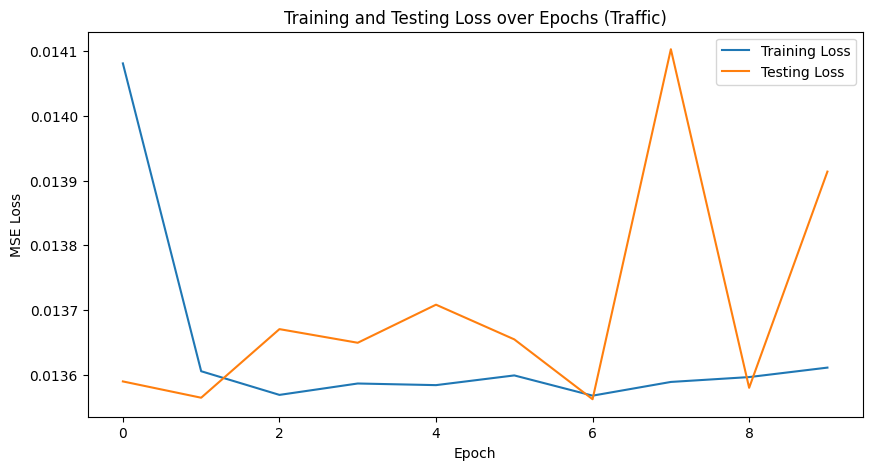

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Load Data Function
def load_data(dataset_type='weather'):
    if dataset_type == 'weather':
        # Load weather dataset (replace with the actual file path)
        df = pd.read_csv("/content/weatherHistory.csv", parse_dates=['Formatted Date'], index_col='Formatted Date')
        data = df['Temperature (C)'].values.reshape(-1, 1)
        seq_len = 24  # Use 24 time steps for prediction (1 day of hourly data)
    elif dataset_type == 'traffic':
        # Load traffic dataset (replace with the actual file path)
        df = pd.read_csv("/content/traffic.csv", parse_dates=['DateTime'], index_col='DateTime')
        data = df['Vehicles'].values.reshape(-1, 1)
        seq_len = 96  # Use 96 time steps for prediction (1 day of 15-min intervals)

    # Normalize the dataset
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Prepare sequences
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])

    return np.array(X), np.array(y), scaler

# Dataset Preparation
dataset_type = 'traffic'  # Change this to 'traffic' for the traffic dataset
X, y, scaler = load_data(dataset_type)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Convert to torch tensors (ensure float32 dtype)
X_train, X_test, X_eval = map(torch.tensor, (X_train, X_test, X_eval))
y_train, y_test, y_eval = map(torch.tensor, (y_train, y_test, y_eval))

X_train, X_test, X_eval = X_train.float(), X_test.float(), X_eval.float()
y_train, y_test, y_eval = y_train.float(), y_test.float(), y_eval.float()

# DataLoader for mini-batches
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
eval_dataset = TensorDataset(X_eval, y_eval)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

# Model Definition
class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        seasonal_init, trend_init = self.decomposition(x)
        seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual:
            seasonal_output = torch.zeros(
                [seasonal_init.size(0), seasonal_init.size(1), self.pred_len],
                dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros(
                [trend_init.size(0), trend_init.size(1), self.pred_len],
                dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](seasonal_init[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](trend_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0, 2, 1)

# Configurations
class Configs:
    seq_len = X.shape[1]
    pred_len = 1
    enc_in = X.shape[2]
    individual = True

configs = Configs()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(configs).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training Loop
num_epochs = 10
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            epoch_test_loss += loss.item()

    test_losses.append(epoch_test_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Evaluation
model.eval()
y_eval_pred = []
y_eval_true = []
with torch.no_grad():
    for X_batch, y_batch in eval_loader:
        X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()
        output = model(X_batch)
        y_eval_pred.append(output.cpu())
        y_eval_true.append(y_batch.cpu())

y_eval_pred = torch.cat(y_eval_pred, dim=0).numpy().flatten()
y_eval_true = torch.cat(y_eval_true, dim=0).numpy().flatten()

# Metrics
mae = mean_absolute_error(y_eval_true, y_eval_pred)
mse = mean_squared_error(y_eval_true, y_eval_pred)
print(f"Evaluation MAE: {mae:.4f}")
print(f"Evaluation MSE: {mse:.4f}")

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Training and Testing Loss over Epochs ({dataset_type.capitalize()})")
plt.legend()
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import random

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# If using CUDA (GPU), set the seed for CUDA as well
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Load Data Function
def load_data(dataset_type='weather'):
    if dataset_type == 'weather':
        # Load weather dataset (replace with the actual file path)
        df = pd.read_csv("/content/weatherHistory.csv", parse_dates=['Formatted Date'], index_col='Formatted Date')
        data = df['Temperature (C)'].values.reshape(-1, 1)
        seq_len = 24  # Use 24 time steps for prediction (1 day of hourly data)
    elif dataset_type == 'traffic':
        # Load traffic dataset (replace with the actual file path)
        df = pd.read_csv("/content/traffic.csv", parse_dates=['DateTime'], index_col='DateTime')
        data = df['Vehicles'].values.reshape(-1, 1)
        seq_len = 96  # Use 96 time steps for prediction (1 day of 15-min intervals)

    # Normalize the dataset
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Prepare sequences
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])

    return np.array(X), np.array(y), scaler

# Dataset Preparation
dataset_type = 'traffic'  # Change this to 'traffic' for the traffic dataset
X, y, scaler = load_data(dataset_type)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Convert to torch tensors (ensure float32 dtype)
X_train, X_test, X_eval = map(torch.tensor, (X_train, X_test, X_eval))
y_train, y_test, y_eval = map(torch.tensor, (y_train, y_test, y_eval))

X_train, X_test, X_eval = X_train.float(), X_test.float(), X_eval.float()
y_train, y_test, y_eval = y_train.float(), y_test.float(), y_eval.float()

# DataLoader for mini-batches
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
eval_dataset = TensorDataset(X_eval, y_eval)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

# Model Definition
class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len, self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, x):
        seasonal_init, trend_init = self.decomposition(x)
        seasonal_init, trend_init = seasonal_init.permute(0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual:
            seasonal_output = torch.zeros(
                [seasonal_init.size(0), seasonal_init.size(1), self.pred_len],
                dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros(
                [trend_init.size(0), trend_init.size(1), self.pred_len],
                dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](seasonal_init[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](trend_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0, 2, 1)

# Configurations
class Configs:
    seq_len = X.shape[1]
    pred_len = 1
    enc_in = X.shape[2]
    individual = True

configs = Configs()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(configs).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training Loop
num_epochs = 10
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            epoch_test_loss += loss.item()

    test_losses.append(epoch_test_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Evaluation
model.eval()
y_eval_pred = []
y_eval_true = []
with torch.no_grad():
    for X_batch, y_batch in eval_loader:
        X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()
        output = model(X_batch)
        y_eval_pred.append(output.cpu())
        y_eval_true.append(y_batch.cpu())

y_eval_pred = torch.cat(y_eval_pred, dim=0).numpy().flatten()
y_eval_true = torch.cat(y_eval_true, dim=0).numpy().flatten()

# Metrics
mae = mean_absolute_error(y_eval_true, y_eval_pred)
mse = mean_squared_error(y_eval_true, y_eval_pred)
print(f"Evaluation MAE: {mae:.4f}")
print(f"Evaluation MSE: {mse:.4f}")

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Training and Testing Loss over Epochs ({dataset_type.capitalize()})")
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/traffic.csv'